<a href="https://colab.research.google.com/github/tns2240/Image-Processing/blob/MobileNetV2-Project/Rice_Leaf_Diseases_Classification_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imported Libraries



In [ ]:
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#Data Loading and Preprocessing

In [ ]:
# Dataset Link: https://www.kaggle.com/datasets/dedeikhsandwisaputra/rice-leafs-disease-dataset
# Mount Drive to access the ZIP
drive.mount('/content/drive')

# Path to ZIP file in Drive
file_path = '/content/drive/MyDrive/Rice Disease Dataset.zip' # Corrected file path

# Check if the file exists before attempting to extract
if not os.path.exists(file_path):
    print(f"Error: The file was not found at {file_path}")
else:
    # Extract to local Colab VM (not Drive)
    extract_path = '/content/rice_disease_data'
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    data_dir = os.path.join(extract_path, 'RiceLeafsDisease')
    train_dir = os.path.join(data_dir, 'train')
    val_dir   = os.path.join(data_dir, 'validation')

    print("Extracted folders:", os.listdir(extract_path))
    print('\n')

    class_names = sorted(os.listdir(train_dir))

    # Build label-to-index mapping from class names
    label_to_index = {name: idx for idx, name in enumerate(class_names)}

    # Count samples per class in the train set
    print("Sample count per class:")
    for label in class_names:
        class_dir = os.path.join(train_dir, label)
        count = len(os.listdir(class_dir))
        print(f"{label}: {count} images")

    # Loading train image paths and labels
    train_image_paths = []
    train_labels = []

    for label in class_names:
        class_dir = os.path.join(train_dir, label)
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            train_image_paths.append(fpath)
            train_labels.append(label_to_index[label])

    # Convert to NumPy arrays
    train_image_paths = np.array(train_image_paths)
    train_labels = np.array(train_labels)
    print(f"\nTotal training samples: {len(train_image_paths)} (before split)")

    # Splitting 80% train 20% test
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        train_image_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
    )

    # Loading validation set
    val_image_paths, val_labels = [], []

    for label in class_names:
        class_path = os.path.join(val_dir, label)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            val_image_paths.append(fpath)
            val_labels.append(label_to_index[label])

    # Convert to NumPy arrays
    val_paths = np.array(val_image_paths)
    val_labels = np.array(val_labels)

    IMG_SIZE = (224, 224)

    def process_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE) # Resizing each sample to 224x224
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Preprocess image for MobileNetV2
        return image, tf.one_hot(label, depth=len(class_names))

    def build_dataset(paths, labels):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(128).prefetch(tf.data.AUTOTUNE)
        return ds

    # Building dataset (train, test and validation)
    train_ds = build_dataset(train_paths, train_labels)
    val_ds   = build_dataset(val_paths, val_labels)
    test_ds  = build_dataset(test_paths, test_labels)

    print("\nDataset Split Summary:")
    print(f"Train samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}")
    print('\n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted folders: ['RiceLeafsDisease']


Sample count per class:
bacterial_leaf_blight: 350 images
brown_spot: 350 images
healthy: 350 images
leaf_blast: 350 images
leaf_scald: 350 images
narrow_brown_spot: 350 images

Total training samples: 2100 (before split)

Dataset Split Summary:
Train samples: 1680
Validation samples: 528
Test samples: 420




#Data Visualization

Image batch shape: (128, 224, 224, 3)
Label batch shape: (128, 6)




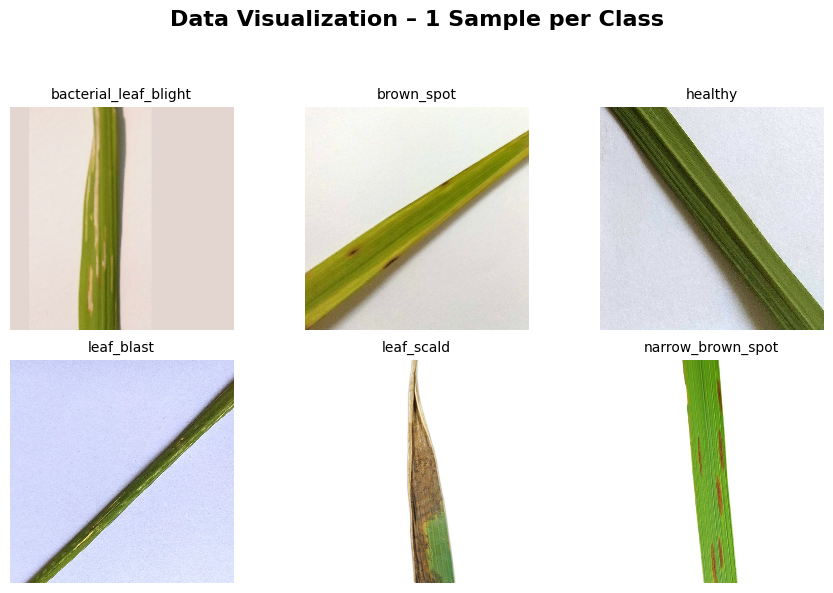

In [ ]:
# Reverse MobileNetV2 preprocessing: [-1, 1] → [0, 255]
def restore_image(img):
    img = (img + 1.0) * 127.5
    return tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8)

# Peek into a batch
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
print('\n')

# Map class indices back to names
index_to_label = {v: k for k, v in label_to_index.items()}

# Collect 1 image per class
samples_per_class = {label: [] for label in range(len(class_names))}

for image, label in train_ds.unbatch():
    label_idx = tf.argmax(label).numpy()
    if len(samples_per_class[label_idx]) < 1:
        samples_per_class[label_idx].append(image)
    if all(len(v) == 1 for v in samples_per_class.values()):
        break  # Stop once we have 1 per class

# Flatten into a single list of (image, label)
sample_images = []
sample_labels = []
for label_idx, imgs in samples_per_class.items():
    sample_images.append(imgs[0])
    sample_labels.append(index_to_label[label_idx])

# Plot 3×2 grid with titles
plt.figure(figsize=(9, 6))
plt.suptitle("Data Visualization – 1 Sample per Class", fontsize=16, fontweight='bold')

for i in range(len(sample_images)):
    plt.subplot(2, 3, i + 1)
    restored_img = restore_image(sample_images[i])
    plt.imshow(restored_img)
    plt.title(sample_labels[i], fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
print('\n')


#Model Definition

In [ ]:
# Device Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device = '/GPU:0'
    print("GPU is available. Using GPU.")
else:
    device = '/CPU:0'
    print("GPU not found. Using CPU.")

print(f"Using device: {device}\n")
tf.debugging.set_log_device_placement(True)  # Logs ops placement

# Build Model with MobileNetV2
with tf.device(device):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze convolutional base

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),  # Preferred over Flatten
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation='softmax')  # Dynamic class count
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


GPU is available. Using GPU.
Using device: /GPU:0



#Model Training and Validation


In [ ]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.1)
    ]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.4398 - loss: 1.4869

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.4499 - loss: 1.4594 - val_accuracy: 0.8220 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8087 - loss: 0.4849

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8096 - loss: 0.4828 - val_accuracy: 0.8712 - val_loss: 0.3598 - learning_rate: 0.0010
Epoch 3/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.8654 - loss: 0.3614

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8664 - loss: 0.3589 - val_accuracy: 0.9034 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 4/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9077 - loss: 0.2821

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9080 - loss: 0.2805 - val_accuracy: 0.9186 - val_loss: 0.2491 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9157 - loss: 0.2378

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9160 - loss: 0.2369 - val_accuracy: 0.9186 - val_loss: 0.2301 - learning_rate: 0.0010
Epoch 6/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9237 - loss: 0.2004

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9246 - loss: 0.1986 - val_accuracy: 0.9186 - val_loss: 0.2116 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9393 - loss: 0.1632

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9396 - loss: 0.1628 - val_accuracy: 0.9261 - val_loss: 0.2009 - learning_rate: 0.0010
Epoch 8/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9461 - loss: 0.1623

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9471 - loss: 0.1596 - val_accuracy: 0.9318 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 9/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9555 - loss: 0.1218

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9557 - loss: 0.1218 - val_accuracy: 0.9299 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 10/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.9677 - loss: 0.1102

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9676 - loss: 0.1102 - val_accuracy: 0.9299 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 11/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.9700 - loss: 0.1024

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9688 - loss: 0.1031 - val_accuracy: 0.9356 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 12/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9655 - loss: 0.1069

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9667 - loss: 0.1050 - val_accuracy: 0.9451 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 13/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9773 - loss: 0.0809

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9772 - loss: 0.0811 - val_accuracy: 0.9413 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9720 - loss: 0.0774

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9722 - loss: 0.0773 - val_accuracy: 0.9337 - val_loss: 0.1492 - learning_rate: 0.0010
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9808 - loss: 0.0697 - val_accuracy: 0.9375 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 16/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9729 - loss: 0.0726 - val_accuracy: 0.9356 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 17/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9855 - loss: 0.0599

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9856 - loss: 0.0599 - val_accuracy: 0.9432 - val_loss: 0.1423 - learning_rate: 0.0010
Epoch 18/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9851 - loss: 0.0509 - val_accuracy: 0.9337 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 19/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.9841 - loss: 0.0508

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9845 - loss: 0.0502 - val_accuracy: 0.9337 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 20/20
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9903 - loss: 0.0470

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9902 - loss: 0.0469 - val_accuracy: 0.9432 - val_loss: 0.1413 - learning_rate: 0.0010
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9554 - loss: 0.1298
Test Accuracy: 95.24%


#Loss and Accuracy curve

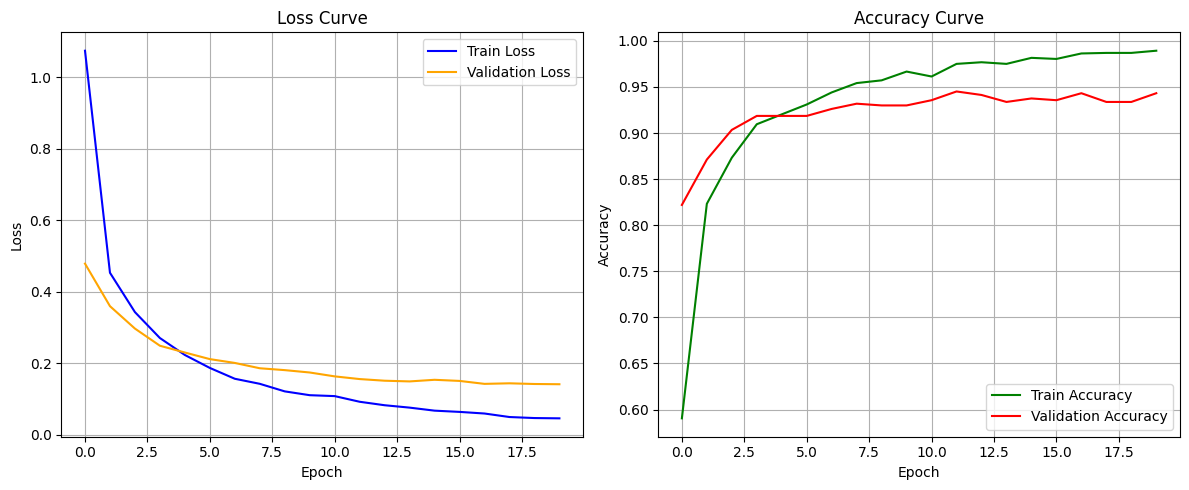

In [ ]:
# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss Curve
ax1.plot(history.history["loss"], label="Train Loss", color='blue')
ax1.plot(history.history["val_loss"], label="Validation Loss", color='orange')
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy Curve
ax2.plot(history.history["accuracy"], label="Train Accuracy", color='green')
ax2.plot(history.history["val_accuracy"], label="Validation Accuracy", color='red')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#Confusion Matrix Display

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


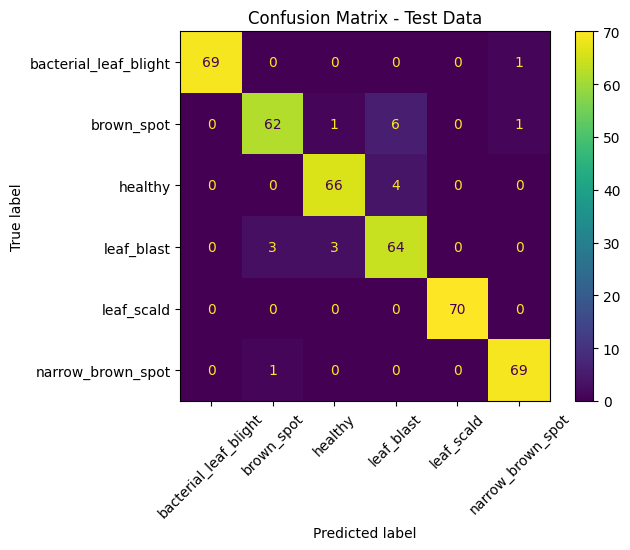

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.99      0.99        70
           brown_spot       0.94      0.89      0.91        70
              healthy       0.94      0.94      0.94        70
           leaf_blast       0.86      0.91      0.89        70
           leaf_scald       1.00      1.00      1.00        70
    narrow_brown_spot       0.97      0.99      0.98        70

             accuracy                           0.95       420
            macro avg       0.95      0.95      0.95       420
         weighted avg       0.95      0.95      0.95       420



In [ ]:
# Get predictions
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # assuming one-hot labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Test Data")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))